# Машинное обучение, ШАД
## Домашнее задание 5: Доверительные интервалы в линейных моделях

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.stats as sps
from matplotlib.lines import Line2D
from pyparsing import Union
from traitlets import List
from typing import Callable, Optional, Tuple, Union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.base import RegressorMixin
from statsmodels.regression.linear_model import RegressionResultsWrapper
# допиши необходимые импорты

sns.set_theme(palette="Set2", font_scale=1.2)

### Ссылки на использование ИИ

Если при решении задач использовался ИИ, укажи здесь публичные ссылки на все чаты с ИИ и поясни, для каких целей он применялся. Обрати внимание на <a href="https://thetahat.ru/courses/ai-rules">правила</a>.

**Задача 1**
1. ссылка
    - для чего использована
    - для чего использована
2. ссылка
    - для чего использована

**Задача 2**
1. ссылка
    - для чего использована


---
### Задача 1.

*В условии этой задачи подробно расписаны алгоритмы решения каждого пункта. Перед выполнением ознакомьтесь также с примерами, которые были рассказаны на лекции, они во многом аналогичны. Предполагается теоретический вывод всех формул, а также их исследование с помощью семплирования. При возникновении затруднений спрашивайте вопросы в чате.*

Пусть $X_1,...,X_n$ &mdash; выборка (независимые одинаково распределенные случайные величины) из экспоненциального распределения с плотностью $p_\theta(x) = \theta e^{-\theta x},$ где $x>0, \theta>0$.

> Такое распределение описывает *время до наступления некоторого события* в условиях, когда события происходят независимо друг от друга. Например, таким событием может быть поступление очередного заказа таксисту или курьеру службы доставки. В таком случае $X_i$ &mdash; время ожидания $i$-го заказа после завершения предыдущего.
>
> Параметр $\theta$ имеет смысл *интенсивности заказов в единицу времени*. Следовательно, чем больше $\theta$, тем меньше среднее значение $X_i$, а точнее $\mathsf{E}_\theta X_i = 1/\theta$. Иначе говоря, если приходит в среднем $\theta=15$ заказов в час, то среднее время между заказами составляет $\mathsf{E}_\theta X_i = 1/\theta = 1/15$ часа или $4$ минуты.
>
> Интересный факт: экспоненциальное распределение является единственным непрерывным распределением, обладающим *свойством отсутствия памяти*: для любых $s,t > 0$ выполнено $\mathsf{P}_{\theta}(X_1 > t + s \mid X_1 > s) = \mathsf{P}_{\theta}(X_1 > t)$. Свойство говорит о том, что если следующего заказа ожидаем уже $s$ минут после
получения предыдущего, то в среднем ждать осталось столько же, как будто бы предыдущий заказ только что пришел.
>
> При выполнении задач используйте следующий факт: $\mathsf{E}_\theta X_i^k = k!/\theta^k$.

**1.** Постройте график плотности экспоненциального распределения.

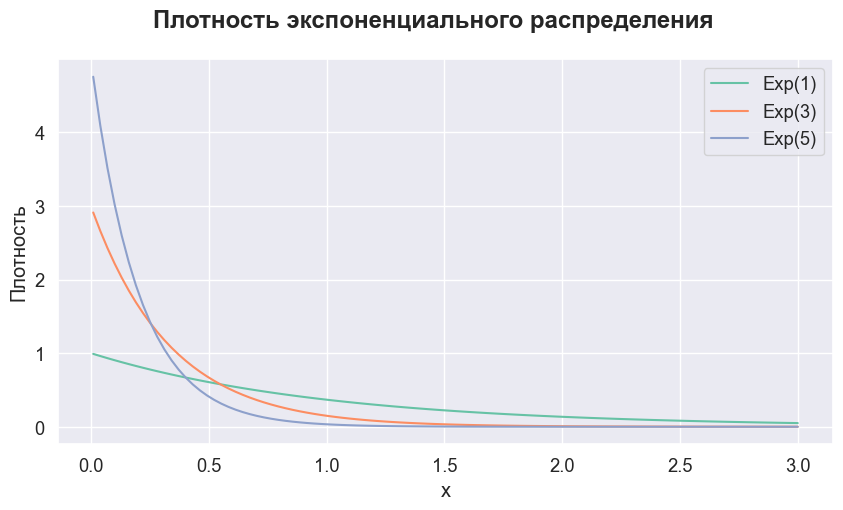

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

list_theta = [1, 3, 5]

for i, theta in enumerate(list_theta):

    x_grid = np.linspace(0.01, 3, num = 100)
    y_grid = theta * (np.exp(-theta * x_grid)) * (x_grid > 0)

    ax.plot(x_grid, y_grid, label = f'Exp({theta})')

ax.set_xlabel('x')
ax.set_ylabel('Плотность')
ax.legend()

fig.suptitle('Плотность экспоненциального распределения', fontweight='bold')

plt.tight_layout
plt.show()

**2.** *Этот пункт был разобран на лекции, но полезно его повторить*. Предложите асимптотически нормальную оценку $\theta$ и найдите ее асимптотическую дисперсию.

* Для выполнения этого пункта запишите центральную предельную теорему. Для какой функции $h(\theta)$ тем самым получилась асимптотически нормальная оценка?

* Какую функцию нужно применить, чтобы получить оценку для $\theta$?

* Воспользуйтесь дельта-методом, чтобы получить асимптотически нормальную оценку $\theta$. Не забудьте проверить применимость дельта-метода.

* Посчитайте ее асимптотическую дисперсию по формуле, которую дает дельта-метод. Обратите внимание, что в качестве аргумента производной нужно взять ту величину, для которой мы сначала построили оценку, то есть для $h(\theta)$.

Запишем ЦПТ для математического ожидания:
$$
\sqrt{n}\left(\bar X_n-\frac{1}{\theta}\right) \xrightarrow{d} N\left(0, \frac{1}{\theta^2}\right)
$$

Применим дельта-метод для $g(x)=\frac{1}{x},$ т.к. $\theta > 0,$ то $g$ дифференцируема в точке $\theta$:
$$
\sqrt{n}\left(\frac{1}{\bar X_n}-\theta\right) \xrightarrow{d} N\left(0, \theta^2 \cdot \frac{1}{\theta^2} \cdot \theta^2\right)=N\left(0, \theta^2\right)
$$


In [ ]:
true_theta = 3

for i in range(1, 11):
    X_samples = sps.expon.rvs(scale = 1/true_theta, size = 10*i, random_state = 42)

    asim_norm_hat_theta = 1 / (X_samples.mean())

    print(f'Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера {10*i}: {asim_norm_hat_theta}')

Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 10: 2.9212146142862236
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 20: 3.2896708548874565
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 30: 3.723006776512907
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 40: 3.3746613224243323
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 50: 3.546332074674269
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 60: 3.1829891822768923
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 70: 3.140830073543694
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 80: 3.203857076749403
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки размера 90: 3.2046750472659378
Асимптотическая нормальная оценка через ЦПТ для матожидания для выборки разме

**3.** *Этот пункт был разобран на лекции, но полезно его повторить*. Постройте асимптотический доверительный интервал Вальда для параметра $\theta$ уровня доверия $\alpha$. Не забудьте заменить $\theta$ в асимптотической дисперсии на соответствующую оценку.

Воспользуемся состоятельной оценкой асимптотической дисперсии $\dfrac{1}{\bar X_{n}^2},$ тогда
$$
\frac{\sqrt{n}\left(\frac{1}{\bar X_n}-\theta\right)}{\frac{1}{\bar X_{n}}} \approx N(0, 1)
$$

Тогда интервал будет иметь вид
$$
\frac{1}{\bar X_n} - \frac{z_{(1+\alpha)/2}}{\bar X_{n}\sqrt{n}} \leq \theta \leq \frac{1}{\bar X_n} + \frac{z_{(1+\alpha)/2}}{\bar X_{n}\sqrt{n}}
$$

In [ ]:
true_theta = 3

alpha = 0.97

for i in range(1, 11):
    X_samples = sps.expon.rvs(scale = 1/true_theta, size = 10*i, random_state = 42)

    asim_norm_hat_theta = 1 / (X_samples.mean())
    left_ppf = sps.norm.ppf((1 + alpha) / 2)
    right_ppf = sps.norm.ppf((1 + alpha) / 2)
    sqrt_n = np.sqrt(10*i)

    left_bound = asim_norm_hat_theta - (left_ppf * asim_norm_hat_theta / sqrt_n)
    right_bound = asim_norm_hat_theta + (right_ppf * asim_norm_hat_theta / sqrt_n)

    print(f'Доверительный интервал Вальда для выборки размера {10*i}: [{left_bound}, {right_bound}]')

Доверительный интервал Вальда для выборки размера 10: [0.9165520240365166, 4.925877204535931]
Доверительный интервал Вальда для выборки размера 20: [1.6933680726272704, 4.885973637147643]
Доверительный интервал Вальда для выборки размера 30: [2.2479422441713544, 5.19807130885446]
Доверительный интервал Вальда для выборки размера 40: [2.2167427506867243, 4.53257989416194]
Доверительный интервал Вальда для выборки размера 50: [2.457972958946907, 4.634691190401631]
Доверительный интервал Вальда для выборки размера 60: [2.291251007985643, 4.0747273565681414]
Доверительный интервал Вальда для выборки размера 70: [2.326175984180698, 3.95548416290669]
Доверительный интервал Вальда для выборки размера 80: [2.4265261231099657, 3.9811880303888403]
Доверительный интервал Вальда для выборки размера 90: [2.471613287071772, 3.9377368074601033]
Доверительный интервал Вальда для выборки размера 100: [2.5678905955269444, 3.991292637381889]


**4.** Из решения предыдущих пунктов несложно получить асимптотически нормальную оценку и доверительный интервал Вальда для $\psi = 1/\theta$ &mdash; среднее время между заказами. Сделайте это.

$$
\sqrt{n}\left(\bar X_n-\frac{1}{\theta}\right) \xrightarrow{d} N\left(0, \frac{1}{\theta^2}\right)
$$
$$
\frac{\sqrt{n}\left(\bar X_n-\frac{1}{\theta}\right)}{\bar X_{n}} \approx N(0, 1)
$$
$$
\bar X_n - \frac{z_{(1+\alpha)/2}\bar X_{n}}{\sqrt{n}} \leq \frac{1}{\theta} \leq \bar X_n + \frac{z_{(1+\alpha)/2}\bar X_{n}}{\sqrt{n}}
$$

In [ ]:
true_theta = 3

alpha = 0.97

for i in range(1, 11):
    X_samples = sps.expon.rvs(scale = 1/true_theta, size = 10*i, random_state = 42)

    asim_norm_hat_theta = X_samples.mean()
    left_ppf = sps.norm.ppf((1 + alpha) / 2)
    right_ppf = sps.norm.ppf((1 + alpha) / 2)
    sqrt_n = np.sqrt(10*i)

    left_bound = asim_norm_hat_theta - (left_ppf * asim_norm_hat_theta / sqrt_n)
    right_bound = asim_norm_hat_theta + (right_ppf * asim_norm_hat_theta / sqrt_n)

    print(f'Доверительный интервал Вальда для выборки размера {10*i}: [{left_bound}, {right_bound}]')

Доверительный интервал Вальда для выборки размера 10: [0.10740640770019644, 0.5772403109006841]
Доверительный интервал Вальда для выборки размера 20: [0.1564755449851484, 0.4514880137485786]
Доверительный интервал Вальда для выборки размера 30: [0.16218007443154536, 0.3750201296124739]
Доверительный интервал Вальда для выборки размера 40: [0.1946502244702299, 0.39800184011182854]
Доверительный интервал Вальда для выборки размера 50: [0.19544218111839345, 0.36852079749908423]
Доверительный интервал Вальда для выборки размера 60: [0.2261529950954494, 0.4021871862460835]
Доверительный интервал Вальда для выборки размера 70: [0.23580536744903988, 0.4009689734637961]
Доверительный интервал Вальда для выборки размера 80: [0.236395226683633, 0.38785234494311926]
Доверительный интервал Вальда для выборки размера 90: [0.24066477190521762, 0.3834234649680641]
Доверительный интервал Вальда для выборки размера 100: [0.23874648243187044, 0.3710855435940438]


**5.** А почему мы применяем центральную предельную теорему именно к исходной выборке? Почему бы не применить ее к выборке $X_1^2,...,X_n^2$?

Сделайте это и получите еще одну асмптотически нормальную оценку $\theta$ и соответствующий доверительный интервал Вальда для параметра $\theta$.

$$
\sqrt{n}\left(\bar X_n^2-\frac{2}{\theta^{2}}\right) \xrightarrow{d} N\left(0, \frac{2}{\theta^2} - \frac{1}{\theta^2}\right) = N\left(0, \frac{1}{\theta^2}\right)
$$

Применим дельта-меотд для $g(x) = \sqrt{\frac{2}{x}},$ тогда $g'(x) = -\sqrt{1/2x^{3}},$
$$
\sqrt{n}\left(\sqrt{\frac{2}{\bar X_n^2}} - \theta\right) \xrightarrow{d} N\left(0, \frac{\theta^{3}}{4}\cdot \frac{1}{\theta^2} \cdot \frac{\theta^{3}}{4}\right) = N\left(0, \frac{\theta^{4}}{16}\right)
$$
$$
\frac{\sqrt{n}\left(\sqrt{\frac{2}{\bar X_n^2}} - \theta\right)}{\frac{1}{2\bar X_{n}^2}} \approx N(0, 1)
$$

Тогда
$$
\frac{\sqrt{2}}{\bar X_n} - \frac{z_{(1+\alpha)/2}}{2\bar X_{n}^2\sqrt{n}} \leq \theta \leq \frac{\sqrt{2}}{\bar X_n} + \frac{z_{(1+\alpha)/2}}{2\bar X_{n}^2\sqrt{n}}
$$

In [ ]:
true_theta = 3

alpha = 0.97

for i in range(1, 11):
    X_samples = sps.expon.rvs(scale = 1/true_theta, size = 10*i, random_state = 42)

    asim_norm_hat_theta = np.sqrt(2) / (X_samples.mean())
    hat_sigma = 1/(2 * (X_samples.mean()**2))
    left_ppf = sps.norm.ppf((1 + alpha) / 2)
    right_ppf = sps.norm.ppf((1 + alpha) / 2)
    sqrt_n = np.sqrt(10*i)

    left_bound = asim_norm_hat_theta - (left_ppf * hat_sigma / sqrt_n)
    right_bound = asim_norm_hat_theta + (right_ppf * hat_sigma / sqrt_n)

    print(f'Доверительный интервал Вальда из ЦТП для квадратов для выборки размера {10*i}: [{left_bound}, {right_bound}]')

Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 10: [1.2031964984509078, 7.059246153801228]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 20: [2.0266417695367895, 7.277952507913881]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 30: [2.5192890513007704, 8.010964301002213]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 40: [2.8187003013085494, 6.72628331986828]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 50: [3.0854294962490334, 6.945112337117101]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 60: [3.082229989366633, 5.920622951559025]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 70: [3.1624594554114527, 5.721149518818104]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 80: [3.2857094914469878, 5.776166768241061]
Доверительный интервал Вальда из ЦТП для квадратов для выборки размера 90: [3.3574

**6.** Для полного счастья давайте построим еще и точный неасимптотический интервал для $\theta$. Известно, что $\overline{X}$ имеет гамма-распределение, воизбежании путаницы с параметрами сразу приведем для него строчку кода `scipy.stats.gamma(a=n, scale=1/(n*theta))`. Если обозначить $\sigma=$ `scale`, то плотность в таком случае имеет вид
$$p(x) = \frac{1}{\sigma^a\Gamma(a)} x^{a-1}e^{-x/\sigma}, x>0,$$
где $\Gamma(x)$ &mdash; гамма-функция.

Чтобы построить интервал, выберите две квантили этого гамма-распределения и получите доверительный интервал аналогично тому, как мы это делали на занятии. Обратите внимание, гамма-распределение не симметрично, поэтому придется оставить обе квантили.

<br/><details>
<summary> ➡️ Кликни для показа подсказки </summary>
Надо избавиться от зависимости распределения по $\theta$. Подумай, какое преобразование со случайной величиной стоит выполнить.
</details>

Воспользуемся следующим свойством гамма-распределения: $X \sim \Gamma(a, \sigma)$ и $t>0,$ тогда $tX \sim \Gamma(a, t\sigma).$ Тогда
$$
\theta \bar X_{n} \sim \Gamma\left(n, \theta\frac{1}{n\theta}\right) = \Gamma\left(n, \frac{1}{n}\right)
$$

Тогда интервал имеет вид
$$
g_{(1-\alpha)/2} \leq \theta \bar X_{n} \leq g_{(1+\alpha)/2}
$$
$$
\frac{g_{(1-\alpha)/2}}{\bar X_{n}} \leq \theta \leq \frac{g_{(1+\alpha)/2}}{\bar X_{n}},
$$
где $g_{\delta}$ - квантиль гамма-распределения $\Gamma\left(n, \frac{1}{n}\right)$ уровня $\delta$.

In [ ]:
true_theta = 3

alpha = 0.97

for i in range(1, 11):
    gamma_prod = sps.gamma(a=10*i, scale=1/(10*i))

    X_samples = sps.expon.rvs(scale = 1/true_theta, size = 10*i, random_state = 42)

    left_ppf = gamma_prod.ppf((1 - alpha) / 2)
    right_ppf = gamma_prod.ppf((1 + alpha) / 2)

    left_bound = left_ppf / X_samples.mean()
    right_bound = right_ppf / X_samples.mean()

    print(f'Точный доверительный интервал для выборки размера {10*i}: [{left_bound}, {right_bound}]')

Точный доверительный интервал для выборки размера 10: [1.2868675777373562, 5.271714287704172]
Точный доверительный интервал для выборки размера 20: [1.9008560302417332, 5.08350688233554]
Точный доверительный интервал для выборки размера 30: [2.404039658935766, 5.347994243676797]
Точный доверительный интервал для выборки размера 40: [2.322660638425031, 4.6348502953476]
Точный доверительный интервал для выборки размера 50: [2.546895746188494, 4.72086576072213]
Точный доверительный интервал для выборки размера 60: [2.357691261102999, 4.139288662690885]
Точный доверительный интервал для выборки размера 70: [2.3823233609714296, 4.010158832397256]
Точный доверительный интервал для выборки размера 80: [2.4766063751053826, 4.0300378261549366]
Точный доверительный интервал для выборки размера 90: [2.5161145709461157, 3.9812060712211848]
Точный доверительный интервал для выборки размера 100: [2.6088576306335955, 4.031357521189969]


**7.** Мы построили три доверительных интервала для параметра $\theta$. Какой из них лучше?

Повторите эксперимент, показанный на занятии,
* построив визуализации доверительны интервалов при увеличении размера выборки,
* оценив долю покрытия параметра интервалом.

Кроме этого, оцените и визуализируйте также среднюю длину каждого интервала в зависимости от размера выборки.

In [ ]:
ArrayLike = Union[np.ndarray, list]


def calculate_sequential_intervals(
    sample: np.ndarray, interval_calculator: Callable, alpha: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Последовательно рассчитывает интервалы для нарастающих срезов выборки.

    Args:
        sample: Входная выборка.
            - 1D array: одна выборка.
            - 2D array: множество выборок, где каждая строка - отдельная выборка.
        interval_calculator: Функция для расчета интервала.
        alpha: Уровень доверия.

    Returns:
        Кортеж из трех массивов: (нижние границы, верхние границы, оценки).
    """
    # Запоминаем, был ли вход 1D
    is_1d = sample.ndim == 1
    data = np.atleast_2d(sample)

    num_experiments, sample_size = data.shape
    lower_bounds = np.full((num_experiments, sample_size), np.nan)
    upper_bounds = np.full((num_experiments, sample_size), np.nan)
    estimates = np.full((num_experiments, sample_size), np.nan)

    # Расчет начинается с выборки размером 2 (индекс i=1)
    for i in range(1, sample_size):
        current_slice = data[:, : i + 1]
        estimate, lower, upper = interval_calculator(current_slice, alpha=alpha)
        lower_bounds[:, i] = lower
        upper_bounds[:, i] = upper
        estimates[:, i] = estimate

    if is_1d:
        # Если на входе был 1D массив
        return lower_bounds.squeeze(), upper_bounds.squeeze(), estimates.squeeze()
    else:
        return lower_bounds, upper_bounds, estimates


def draw_confidence_interval(
    left: ArrayLike,
    right: ArrayLike,
    estimation: Optional[ArrayLike] = None,
    sample: Optional[ArrayLike] = None,
    ylim: Tuple[Optional[float], Optional[float]] = (None, None),
    color_estimation: str = "#FF3300",
    color_interval: str = "#00CC66",
    color_sample: str = "#0066FF",
    label_estimation: Optional[str] = None,
    label_interval: Optional[str] = None,
) -> None:
    """Рисует доверительный интервал и оценку в зависимости от размера выборки.

    Args:
        left (ArrayLike): Массив левых (нижних) границ интервалов.
        right (ArrayLike): Массив правых (верхних) границ интервалов.
        estimation (Optional[ArrayLike]): Массив точечных оценок (по умолчанию None).
        sample (Optional[ArrayLike]): Исходная выборка для отображения (по умолчанию None).
        ylim (tuple, optional): Кортеж для ограничения вертикальной оси (ymin, ymax).
        color_estimation (str): Цвет для линии точечной оценки.
        color_interval (str): Цвет для закрашенной области интервала.
        color_sample (str): Цвет для точек исходной выборки.
        label_estimation (Optional[str]): Текстовая метка для линии оценки в легенде.
        label_interval (Optional[str]): Текстовая метка для области интервала в легенде.
    """

    sample_sizes = np.arange(len(left)) + 1

    assert len(sample_sizes) == len(right)

    if not sample is None:
        plt.scatter(
            sample_sizes,
            sample,
            alpha=0.3,
            color=color_sample,
            s=40,
            label="Элемент выборки",
        )

    if not estimation is None:
        plt.plot(
            sample_sizes,
            estimation,
            color=color_estimation,
            linewidth=2.5,
            label=label_estimation,
        )

    plt.fill_between(
        sample_sizes,
        left,
        right,
        alpha=0.25,
        color=color_interval,
        label=label_interval,
    )
    plt.legend()
    plt.ylim(ylim)
    plt.xlabel("Размер выборки")
    plt.title("Зависимость доверительного интервала от размера выборки")

In [ ]:
def wald_confidence_interval(
    sample: np.ndarray, alpha: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    n = sample.shape[0]
    hat_theta = 1 / sample.mean()
    z = sps.norm.ppf((1 + alpha) / 2)

    se = hat_theta / np.sqrt(n)

    left_bound = hat_theta - z * se
    right_bound = hat_theta + z * se

    return hat_theta, left_bound, right_bound

def exact_confidence_interval(
    sample: np.ndarray, alpha: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    n = sample.shape[0]
    hat_theta = 1 / sample.mean()
    gamma_dist = sps.gamma(a=n, scale=1/n)

    left_bound = gamma_dist.ppf((1 - alpha) / 2) / sample.mean()
    right_bound = gamma_dist.ppf((1 + alpha) / 2) / sample.mean()

    return hat_theta, left_bound, right_bound

def sqrt_confidence_interval(
    sample: np.ndarray, alpha: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    n = sample.shape[0]
    hat_theta = np.sqrt(2) / sample.mean()
    hat_sigma = 1 / (2 * (sample.mean() ** 2))
    z = sps.norm.ppf((1 + alpha) / 2)

    left_bound = hat_theta - z * hat_sigma / np.sqrt(n)
    right_bound = hat_theta + z * hat_sigma / np.sqrt(n)

    return hat_theta, left_bound, right_bound

In [ ]:
true_theta = 0.5
alpha = 0.95

max_sample_size = 50

sample = sps.expon.rvs(scale = 1/true_theta, size = max_sample_size, random_state = 52)

left_wald, right_wald, estimation_wald = calculate_sequential_intervals(
    sample,
    wald_confidence_interval,
    alpha=alpha
)

left_exact, right_exact, estimation_exact = calculate_sequential_intervals(
    sample,
    exact_confidence_interval,
    alpha=alpha
)

left_sqrt, right_sqrt, estimation_sqrt = calculate_sequential_intervals(
    sample,
    sqrt_confidence_interval,
    alpha=alpha
)

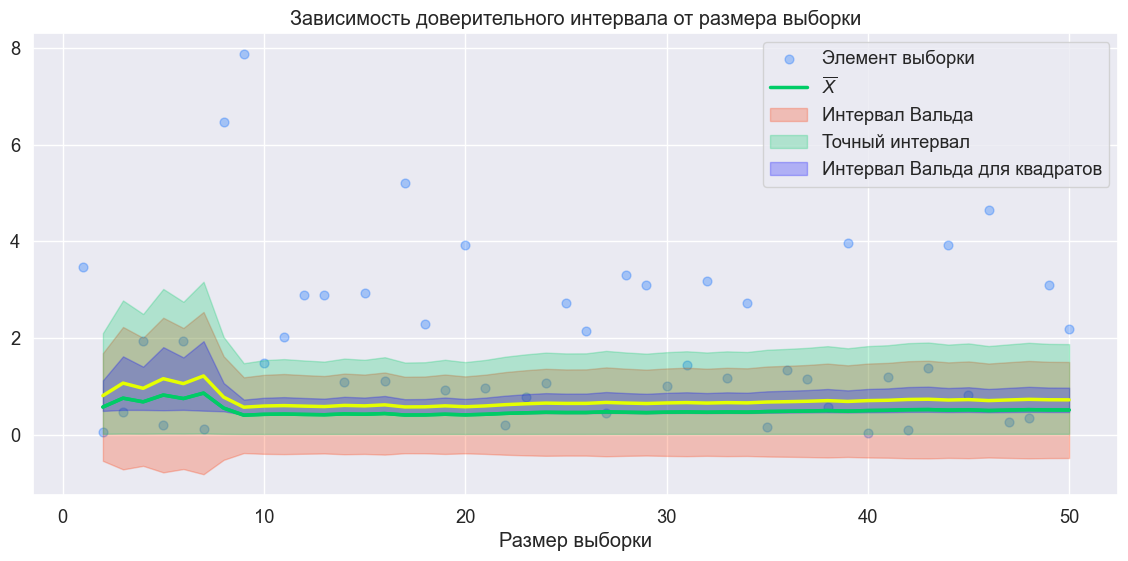

In [ ]:
plt.figure(figsize=(14, 6))

draw_confidence_interval(
    left_wald,
    right_wald,
    estimation_wald,
    sample,
    ylim=(None, None),
    color_estimation="#00CC66",
    color_interval="#FF3300",
    label_estimation="$\\overline{X}$",
    label_interval="Интервал Вальда",
)

draw_confidence_interval(
    left_exact,
    right_exact,
    estimation_exact,
    ylim=(None, None),
    color_estimation="#00CC66",
    color_interval="#00CC66",
    label_interval="Точный интервал",
)

draw_confidence_interval(
    left_sqrt,
    right_sqrt,
    estimation_sqrt,
    ylim=(None, None),
    color_estimation="#E5FF00",
    color_interval="#0000FF",
    label_interval="Интервал Вальда для квадратов",
)

In [ ]:
def get_coverage_rate(left, right, theta):
    """
    Вычисляет долю покрытия параметра доверительным интервалом.
    :param left, right: Массивы левых и правых границ доверительных интервалов
    :param theta: Значение параметра
    """

    return np.mean((left <= theta) & (theta <= right), axis=0)

In [ ]:
n_samples = 100_000
true_theta = 0.7
alpha = 0.95

sample = sps.expon.rvs(scale = 1/true_theta, size = (n_samples, max_sample_size), random_state = 42)

left_wald, right_wald, estimation_wald = calculate_sequential_intervals(
    sample,
    wald_confidence_interval,
    alpha=alpha
)
coverage_rate_wald = get_coverage_rate(left_wald, right_wald, true_theta)

left_exact, right_exact, estimation_exact = calculate_sequential_intervals(
    sample,
    exact_confidence_interval,
    alpha=alpha
)
corevage_rate_exact = get_coverage_rate(left_exact, right_exact, true_theta)

left_sqrt, right_sqrt, estimation_sqrt = calculate_sequential_intervals(
    sample,
    sqrt_confidence_interval,
    alpha=alpha
)
coverage_rate_sqrt = get_coverage_rate(left_sqrt, right_sqrt, true_theta)

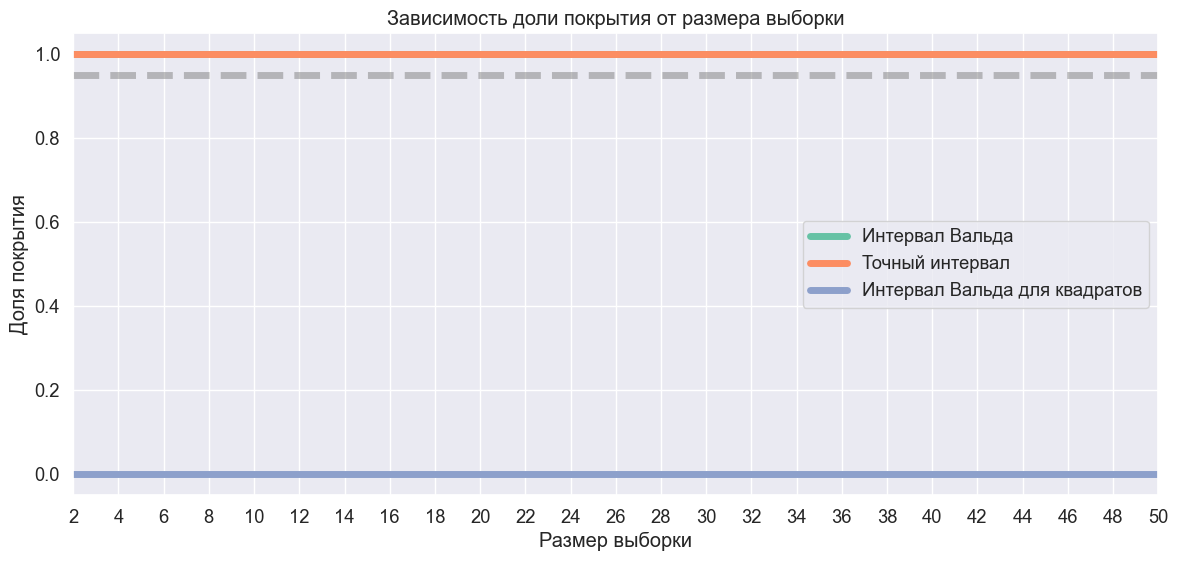

In [ ]:
sample_size_grid = np.arange(max_sample_size) + 1

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(14, 6))
    plt.plot(sample_size_grid[1:], coverage_rate_wald[1:], lw=5, label="Интервал Вальда")
    plt.plot(sample_size_grid[1:], corevage_rate_exact[1:], lw=5, label="Точный интервал")
    plt.plot(sample_size_grid[1:], coverage_rate_sqrt[1:], lw=5, label="Интервал Вальда для квадратов")
    plt.hlines(alpha, 2, max_sample_size, lw=5, color="gray", linestyles="--", alpha=0.5)
    plt.xlim((2, max_sample_size))
    plt.xticks(np.arange(2, max_sample_size + 1, 2))
    plt.legend()
    plt.xlabel("Размер выборки")
    plt.ylabel("Доля покрытия")
    plt.title("Зависимость доли покрытия от размера выборки")

**8.** Какие выводы можно сделать про эти доверительные интервалы?

...

---
### Задача 2.

Рассмотрим датасет [NYC Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data). Этот датасет содержит данные о поездках жёлтых такси в Нью-Йорке за 2016 год. Его собрала компания NYC Taxi and Limousine Commission (TLC) — официальный регулятор такси в Нью-Йорке. Информация включает время и место начала и окончания поездки, её длительность, расстояние, количество пассажиров, тип поставщика и другие характеристики.

Изначально данные использовались в конкурсе на Kaggle, где участникам нужно было создать модель для прогнозирования времени поездки. Набор данных полезен для анализа городского трафика, регрессионных задач, прогнозирования спроса на такси, оценки загруженности районов, моделирования пробок и анализа транспортной инфраструктуры.

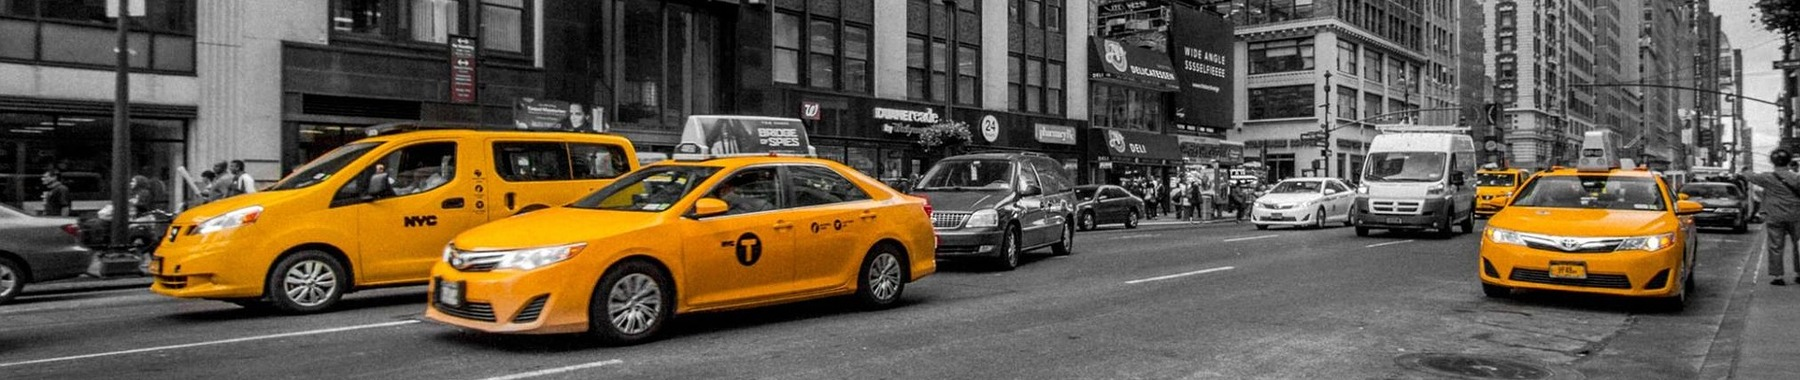

**Описание признаков**

* `id` — уникальный идентификатор поездки;  
* `vendor_id` — идентификатор поставщика (`1` или `2`, разные операторы такси);  
* `pickup_datetime` — дата и время начала поездки;  
* `dropoff_datetime` — дата и время завершения поездки;  
* `passenger_count` — количество пассажиров в машине;  
* `pickup_longitude`, `pickup_latitude` — координаты точки посадки пассажира;  
* `dropoff_longitude`, `dropoff_latitude` — координаты точки высадки пассажира;  
* `store_and_fwd_flag` — индикатор, сохранялись ли данные поездки локально перед передачей (`Y`/`N`);  
* `trip_duration` — длительность поездки в секундах (**таргет**).

**Задача**

Построить модель регрессии для прогнозирования длительности поездки по признакам, доступным в начале поездки — например, по времени, координатам и числу пассажиров.

Также практический интерес представляет построение предсказательных интервалов, позволяющих оценить диапазон возможной продолжительности поездки для конкретного маршрута. Например, *"Поездка от Центрального парка до аэропорта Ла-Гуардия в 8 утра обычно длится от 23 до 27 минут."*


---

Скачаем данные и посмотрим на них

In [ ]:
df = pd.read_csv("./datasets/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df.shape

(1458644, 11)

Данных довольно много. Для отладки кода рекомендуем работать с небольшой подвыборкой

In [ ]:
# Убери этот код для финального прогона
df = df.sample(n=20_000, random_state=42).reset_index(drop=True)

**1.** **Генерация признаков исходя из постановки задачи**

Некоторые преобразования признаков можно совершить только на основе знаний предметной сферы вне зависимости от  конкретных данных. Для удобства в рамках исследования эти преобразования можно сделать сразу на всех данных без деления на трейн и тест.

Переведем секунды в минуты, с ними нам привычнее иметь дело, когда речь идет о поездках на такси по городу

In [ ]:
df["trip_duration_min"] = df["trip_duration"] / 60.0

Также полезно будет учитывать расстояние между точками посадки и высадки пассажиров. Можно использовать евклидово расстояние между координатами (`pickup_longitude`, `pickup_latitude`) и (`dropoff_longitude`, `dropoff_latitude`). Однако, это расстояние не учитывает кривизну Земли. В рамках одного города это может быть не существенно, тем не менее, для наглядности рассмотрим, как вычислить реальное расстояние в километрах.

> Расстояние между двумя точками на поверхности Земли, заданными широтой и долготой можно вычислить по формуле Haversine дугового расстояния
>
> $$
d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\varphi}{2}\right) + \cos \varphi_1 \cos \varphi_2 \sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)
$$
>
> где:  
> - $\varphi_1, \varphi_2$ — широта точек (в радианах),  
> - $\lambda_1, \lambda_2$ — долгота точек (в радианах),  
> - $R = 6371$ км — радиус Земли,  
> - $\Delta\varphi = \varphi_2 - \varphi_1$,
> - $\Delta\lambda = \lambda_2 - \lambda_1$.



In [ ]:
from typing import Union
Coordinate = Union[float, np.ndarray, pd.Series]

def haversine(lat1: Coordinate, lon1: Coordinate, lat2: Coordinate, lon2: Coordinate) -> np.ndarray:
    """
    Вычисляет расстояние между двумя точками на Земле по формуле гаверсина.

    Параметры
    ----------
    lat1: Широта первой точки в градусах.
    lon1: Долгота первой точки в градусах.
    lat2: Широта второй точки в градусах.
    lon2: Долгота второй точки в градусах.

    Возвращает
    -------
    np.ndarray
        Расстояние между точками в километрах.
    """
    R = 6371.0  # Средний радиус Земли в километрах

    # Преобразование градусов в радианы для вычислений
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    # Основная формула Гаверсина
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    # Использование arctan2 для большей точности
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [ ]:
df["distance_km"] = haversine(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"],
)

Посчитаем среднюю скорость в километрах в час. Заметьте, что она определяется на основе таргета, ее нельзя будет использовать как признак.

In [ ]:
df["speed"] = df["distance_km"] / (df["trip_duration_min"] / 60)

Построим признаки на основе даты, вы можете по своему усмотрению использовать их или не использовать

In [ ]:
# День недели (0 = понедельник)
df["weekday"] = df["pickup_datetime"].dt.weekday
# Выходные
df["is_weekend"] = (df["weekday"] >= 5).astype(int)
# Часы
df["hour"] = df["pickup_datetime"].dt.hour
# Утренний час-пик
df["is_peak_morning"] = df["hour"].between(7, 10).astype(int)
# Вечерний час-пик
df["is_peak_evening"] = df["hour"].between(16, 20).astype(int)

Можем добавить какую-то нелинейность. Например, вы можете взять примеры ниже или же предложить свои

In [ ]:
# некоторые признаки можно убрать
df["dist_peak_morning"] = df["distance_km"] * df["is_peak_morning"]
df["dist_peak_evening"] = df["distance_km"] * df["is_peak_evening"]
df["dist_weekend"] = df["distance_km"] * df["is_weekend"]
df["dist2"] = df["distance_km"] ** 2
df["log_dist"] = np.log1p(df["distance_km"])

# придумайте свои признаки исходя из постановки задачи

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,weekday,is_weekend,hour,is_peak_morning,is_peak_evening,dist_peak_morning,dist_peak_evening,dist_weekend,dist2,log_dist
0,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,...,2,0,7,1,0,2.76305,0.000000,0.000000,7.634443,1.325230
1,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,...,6,1,12,0,0,0.00000,0.000000,1.959178,3.838380,1.084912
2,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,...,6,1,2,0,0,0.00000,0.000000,1.404772,1.973384,0.877455
3,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,...,3,0,17,0,1,0.00000,1.978660,0.000000,3.915094,1.091473
4,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N,...,3,0,17,0,1,0.00000,20.837745,0.000000,434.211612,3.083640


Разделите данные на обучающую и тестовую части

In [ ]:
x_data = df.drop(columns=["id", "trip_duration", "pickup_datetime", "dropoff_datetime", "trip_duration_min", "speed", "store_and_fwd_flag", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])
y_data = df["trip_duration_min"]

x_train, x_test, y_train, y_test = train_test_split( x_data, y_data, test_size=0.2, random_state=42)


**2.** **Фильтрация данных**

Посмотрим на распределение данных.
* Постройте гистограммы для длительности поездки и для расстояния.
* Постройте scatterplot для этих двух признаков (указывайте малое значение непрозрачности `alpha` для информативности графика, на полных данных не более 0.01).

Что можно сказать про эти признаки?

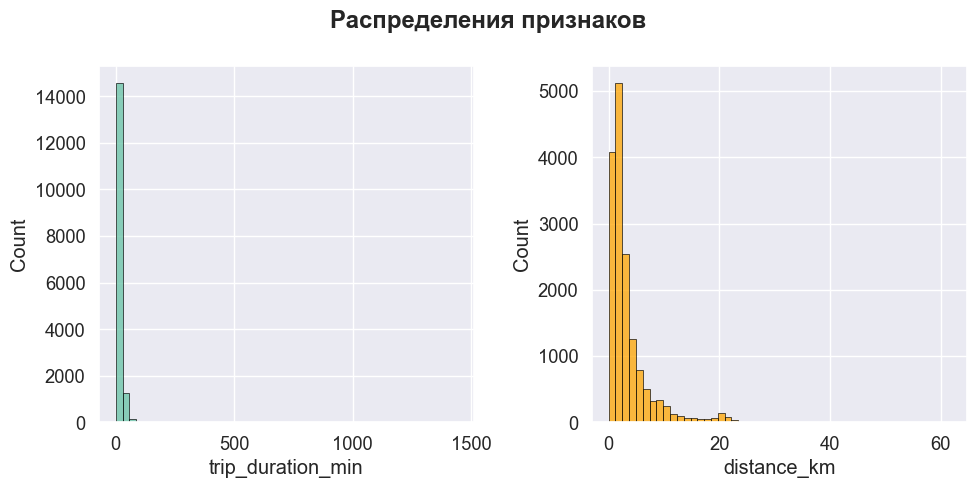

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(y_train, bins=50, ax=ax[0], edgecolor="black", label="Продолжительность поездки (мин)")
sns.histplot(x_train["distance_km"], bins=50, ax=ax[1], edgecolor="black", color="orange", label="Расстояние (км)")

fig.suptitle("Распределения признаков", fontweight='bold')

plt.tight_layout()
plt.show()

Выбросы делают прям больно, поэтому отобразим без них.

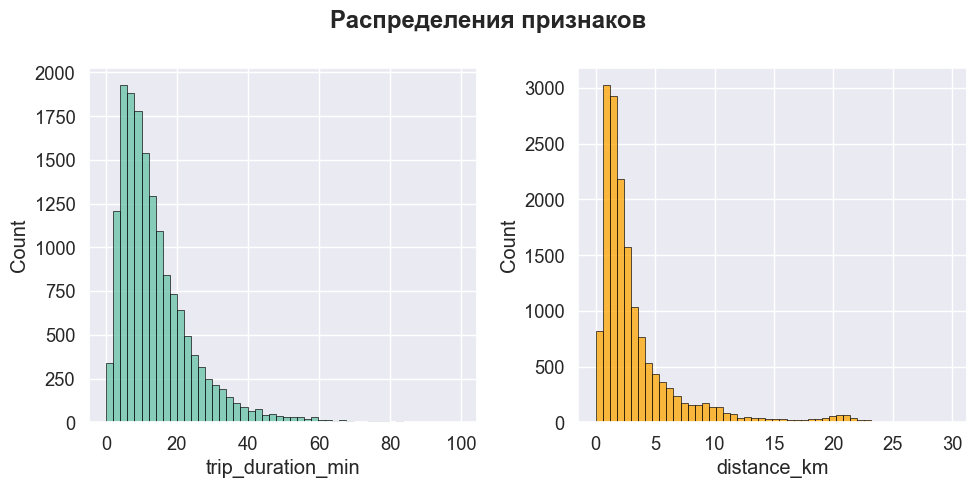

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(y_train[y_train < 100], bins=50, ax=ax[0], edgecolor="black", label="Продолжительность поездки (мин)")
sns.histplot(x_train["distance_km"][x_train["distance_km"] < 30], bins=50, ax=ax[1], edgecolor="black", color="orange", label="Расстояние (км)")

fig.suptitle("Распределения признаков", fontweight='bold')

plt.tight_layout()
plt.show()

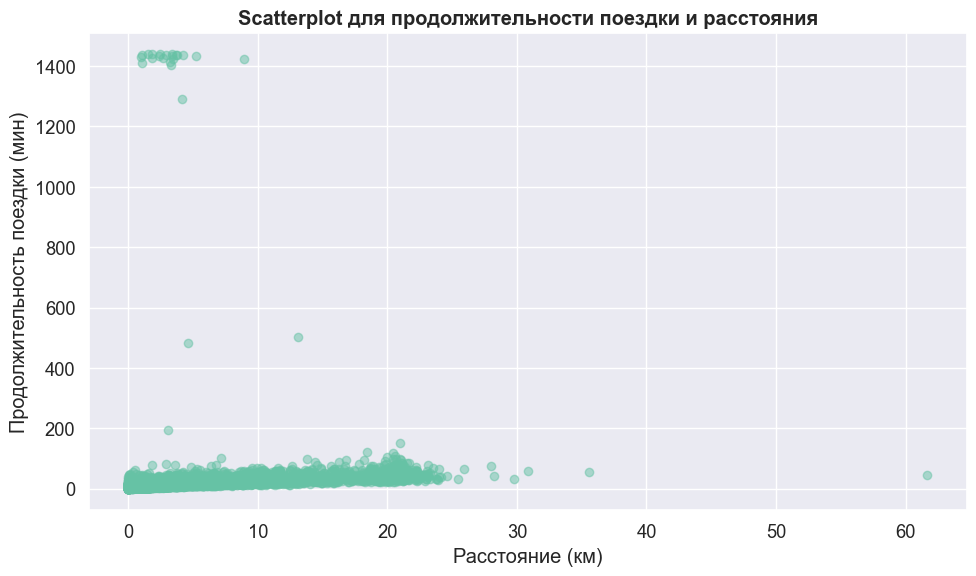

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train["distance_km"], y_train, alpha=0.5)
plt.xlabel("Расстояние (км)")
plt.ylabel("Продолжительность поездки (мин)")
plt.title("Scatterplot для продолжительности поездки и расстояния", fontweight='bold')

plt.tight_layout()
plt.show()

Есть достаточно большие выбросы. Зависимость продолжительности поездки от расстояния линейно.

На графиках явно заметны выбросы, удалите их и снова постройте scatterplot. Сколько процентов данных пришлось удалить?

In [ ]:
temp_df = pd.concat([x_train, y_train], axis=1)


clean_temp_df = temp_df[(temp_df["trip_duration_min"] < 100)]
clean_temp_df = clean_temp_df[(clean_temp_df["distance_km"] < 30)]

clean_x_train = clean_temp_df.drop(columns=["trip_duration_min"])
clean_y_train = clean_temp_df["trip_duration_min"]

print(f"Размер обучающей выборки после удаления выбросов: {clean_x_train.shape[0]}")

prost_deleted = (temp_df.shape[0] - clean_y_train.shape[0]) / temp_df.shape[0] * 100
print(f"Процент данных, которое пришлось удалить: {prost_deleted:.2}%")

Размер обучающей выборки после удаления выбросов: 15967
Процент данных, которое пришлось удалить: 0.21%


In [ ]:
x_train = clean_x_train
y_train = clean_y_train

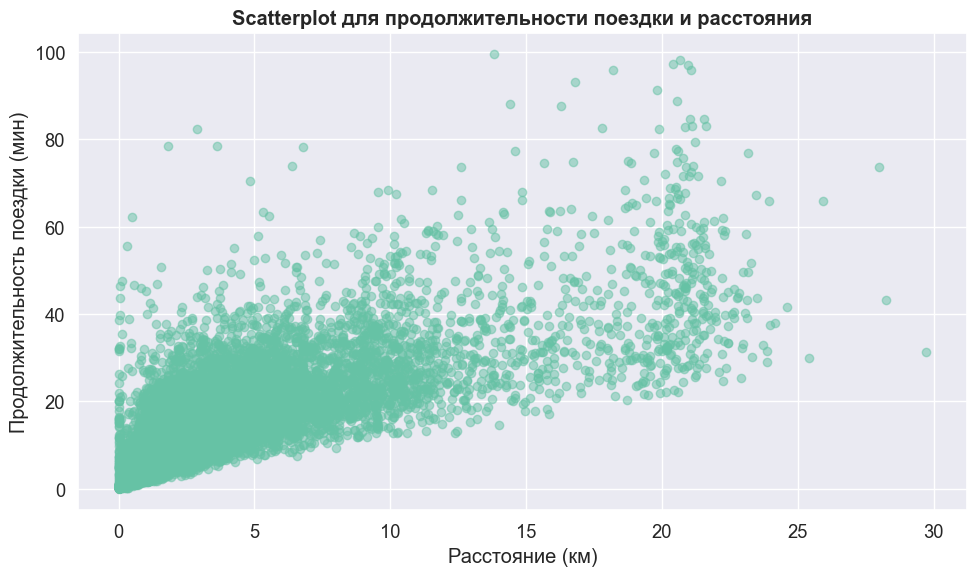

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train["distance_km"], y_train, alpha=0.5)
plt.xlabel("Расстояние (км)")
plt.ylabel("Продолжительность поездки (мин)")
plt.title("Scatterplot для продолжительности поездки и расстояния", fontweight='bold')

plt.tight_layout()
plt.show()

Если вы немного пожалели данные при удалении выбросов выше, на обновленном графике вы увидите еще сгусток выбросов. Возможно, это связано с поездками в определенную точку Нью-Йорка. Такие поездки можно обрабатывать как-то отдельно, сейчас же для простоты сосредоточимся только на обработке основного набора данных.

При необходимости удалите оставшиеся выбросы и снова постройте scatterplot. В результате должны остаться поездки до 15-18 км и до 60-80 минут. Сколько процентов данных пришлось удалить?

In [ ]:
temp_df = pd.concat([x_train, y_train], axis=1)

clean_temp_df = temp_df[(temp_df["trip_duration_min"] < 60)]
clean_temp_df = clean_temp_df[(clean_temp_df["distance_km"] < 15)]

clean_x_train = clean_temp_df.drop(columns=["trip_duration_min"])
clean_y_train = clean_temp_df["trip_duration_min"]

print(f"Размер обучающей выборки после удаления выбросов: {clean_x_train.shape[0]}")

prost_deleted = (temp_df.shape[0] - clean_y_train.shape[0]) / temp_df.shape[0] * 100
print(f"Процент данных, которое пришлось удалить: {prost_deleted:.2}%")

Размер обучающей выборки после удаления выбросов: 15453
Процент данных, которое пришлось удалить: 3.2%


In [ ]:
x_train = clean_x_train
y_train = clean_y_train

Обратите внимание на короткие поездки. На графике можно заметить некоторое количество длительных поездок с нулевым расстоянием. Очевидно, в них что-то пошло не так. Удалите эти точки и снова постройте scatterplot. Все ли теперь хорошо?

In [ ]:
temp_df = pd.concat([x_train, y_train], axis=1)

clean_temp_df = temp_df[(temp_df["distance_km"] > 0.1) + (temp_df["trip_duration_min"] <= 5)]

clean_x_train = clean_temp_df.drop(columns=["trip_duration_min"])
clean_y_train = clean_temp_df["trip_duration_min"]

print(f"Размер обучающей выборки после удаления выбросов: {clean_x_train.shape[0]}")

prost_deleted = (temp_df.shape[0] - clean_y_train.shape[0]) / temp_df.shape[0] * 100
print(f"Процент данных, которое пришлось удалить: {prost_deleted:.2}%")

Размер обучающей выборки после удаления выбросов: 15391
Процент данных, которое пришлось удалить: 0.4%


In [ ]:
x_train = clean_x_train
y_train = clean_y_train

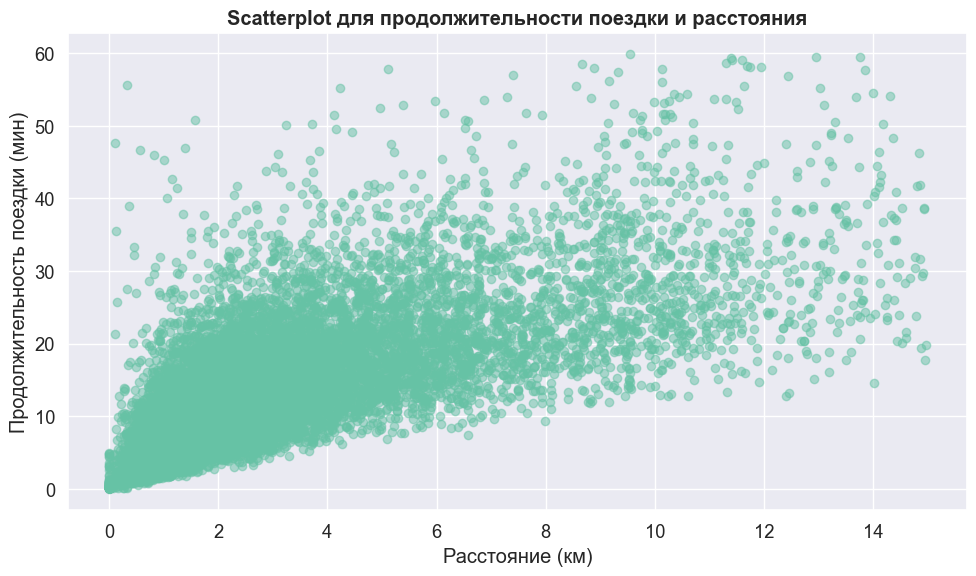

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train["distance_km"], y_train, alpha=0.5)
plt.xlabel("Расстояние (км)")
plt.ylabel("Продолжительность поездки (мин)")
plt.title("Scatterplot для продолжительности поездки и расстояния", fontweight='bold')

plt.tight_layout()
plt.show()

Постройте гистограмму средней скорости. Есть ли среди водителей Шумахеры? Возможно, их стоит убрать.

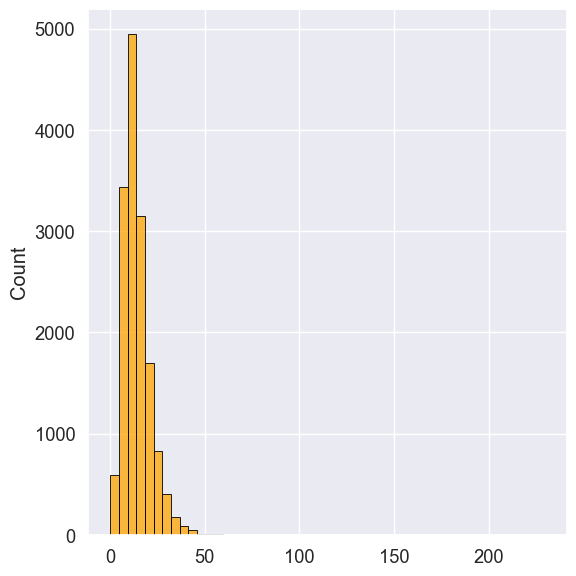

In [ ]:
plt.figure(figsize=(6, 6))

sns.histplot(x_train["distance_km"] / (y_train / 60), bins=50, edgecolor="black", color="orange", label="Расстояние (км)")

fig.suptitle("Распределения признаков", fontweight='bold')

plt.tight_layout()
plt.show()

Да, Шумахеры присутствуют.

In [ ]:
temp_df = pd.concat([x_train, y_train], axis=1)

clean_temp_df = temp_df[(temp_df["distance_km"] / (temp_df["trip_duration_min"] / 60) < 50)]

clean_x_train = clean_temp_df.drop(columns=["trip_duration_min"])
clean_y_train = clean_temp_df["trip_duration_min"]

print(f"Размер обучающей выборки после удаления выбросов: {clean_x_train.shape[0]}")

prost_deleted = (temp_df.shape[0] - clean_y_train.shape[0]) / temp_df.shape[0] * 100
print(f"Процент данных, которое пришлось удалить: {prost_deleted:.2}%")

Размер обучающей выборки после удаления выбросов: 15376
Процент данных, которое пришлось удалить: 0.097%


In [ ]:
x_train = clean_x_train
y_train = clean_y_train

**3.** **Обработка признаков на основе данных**


Выполните необходимые преобразования категориальных признаков

In [ ]:
cat_features = ["vendor_id", "weekday", "is_weekend", "hour", "is_peak_morning", "is_peak_evening"]
num_features = [col for col in x_train.columns if col not in cat_features]

In [ ]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_ohe_cat = ohe.fit_transform(x_train[cat_features])

x_train = pd.concat(
    [
        pd.DataFrame(train_ohe_cat, columns=ohe.get_feature_names_out(cat_features)),
        x_train[num_features].reset_index(drop=True)
    ],
    axis=1
)

x_train.head()

,vendor_id_1,vendor_id_2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,is_weekend_0,...,is_peak_morning_1,is_peak_evening_0,is_peak_evening_1,passenger_count,distance_km,dist_peak_morning,dist_peak_evening,dist_weekend,dist2,log_dist
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1,1.851881,0.000000,1.851881,1.851881,3.429462,1.047979
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1,2.854776,0.000000,0.000000,0.000000,8.149744,1.349313
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1,0.764733,0.000000,0.000000,0.764733,0.584816,0.567999
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1,0.828314,0.828314,0.000000,0.828314,0.686105,0.603394
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
test_ohe_cat = ohe.transform(x_test[cat_features])

x_test = pd.concat(
    [
        pd.DataFrame(test_ohe_cat, columns=ohe.get_feature_names_out(cat_features)),
        x_test[num_features].reset_index(drop=True)
    ],
    axis=1
)

На основе проведенного исследования данных или дополнительного анализа некоторых признаков при желании вы можете построить еще какие-либо преобразования признаков. Эту часть можно пропустить если далее получится хорошее качество модели.

**4.** **Анализ линейной регрессии**

Обучите линейную регрессию без регуляризации и посчитайте качество по метрике $R^2$, а также ошибки $RMSE, MAE, MAPE$ на тестовой выборке. При правильном препроцессинге можно получить $MAPE \sim 20\%$.

In [ ]:
x_train_with_const = sm.add_constant(x_train)

x_train_np = np.array(x_train_with_const)
y_train_np = np.array(y_train)

linear = sm.OLS(y_train_np, x_train_np)
lm_results = linear.fit()

In [ ]:
lm_results.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.059033,0.075264,0.784340,4.328530e-01,-0.088494,0.206559
x1,0.113161,0.056907,1.988539,4.676986e-02,0.001617,0.224705
x2,-0.054129,0.061319,-0.882736,3.773926e-01,-0.174321,0.066064
x3,-0.954779,0.108689,-8.784529,1.734020e-18,-1.167822,-0.741736
x4,-0.047339,0.105662,-0.448024,6.541421e-01,-0.254448,0.159770
x5,0.473703,0.102519,4.620629,3.856915e-06,0.272753,0.674652
x6,0.632592,0.102292,6.184193,6.400316e-10,0.432088,0.833096
x7,0.227808,0.100829,2.259339,2.387629e-02,0.030170,0.425445
x8,0.411524,0.087351,4.711159,2.484724e-06,0.240306,0.582742
x9,-0.684476,0.090276,-7.582013,3.596821e-14,-0.861429,-0.507524


In [ ]:
x_test_with_const = sm.add_constant(x_test)
x_test_np = np.array(x_test_with_const)
y_test_np = np.array(y_test)

y_pred = lm_results.predict(x_test_np)

linreg_r2_score = r2_score(y_test, y_pred)
linreg_rmse = root_mean_squared_error(y_test, y_pred)
linreg_mae = mean_absolute_error(y_test, y_pred)
linreg_mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Linear Regression R2: {linreg_r2_score}')
print(f'Linear Regression RMSE: {linreg_rmse}')
print(f'Linear Regression MAE: {linreg_mae}')
print(f'Linear Regression MAPE: {linreg_mape}')

Linear Regression R2: 0.03393362671683631
Linear Regression RMSE: 52.49231039899626
Linear Regression MAE: 6.3421815625689275
Linear Regression MAPE: 0.4547188645166221


*Прежде чем дальше выполнять домашку, убедись, что ты внимательно изучил все материалы с занятия. Там могут быть ответы на многие твои вопросы. Если все же чего-то не нашлось, спроси в чате.*

Визуализируйте зависимость остатков регрессии от нескольких признаков. Наблюдается ли гетероскедастичность остатков?

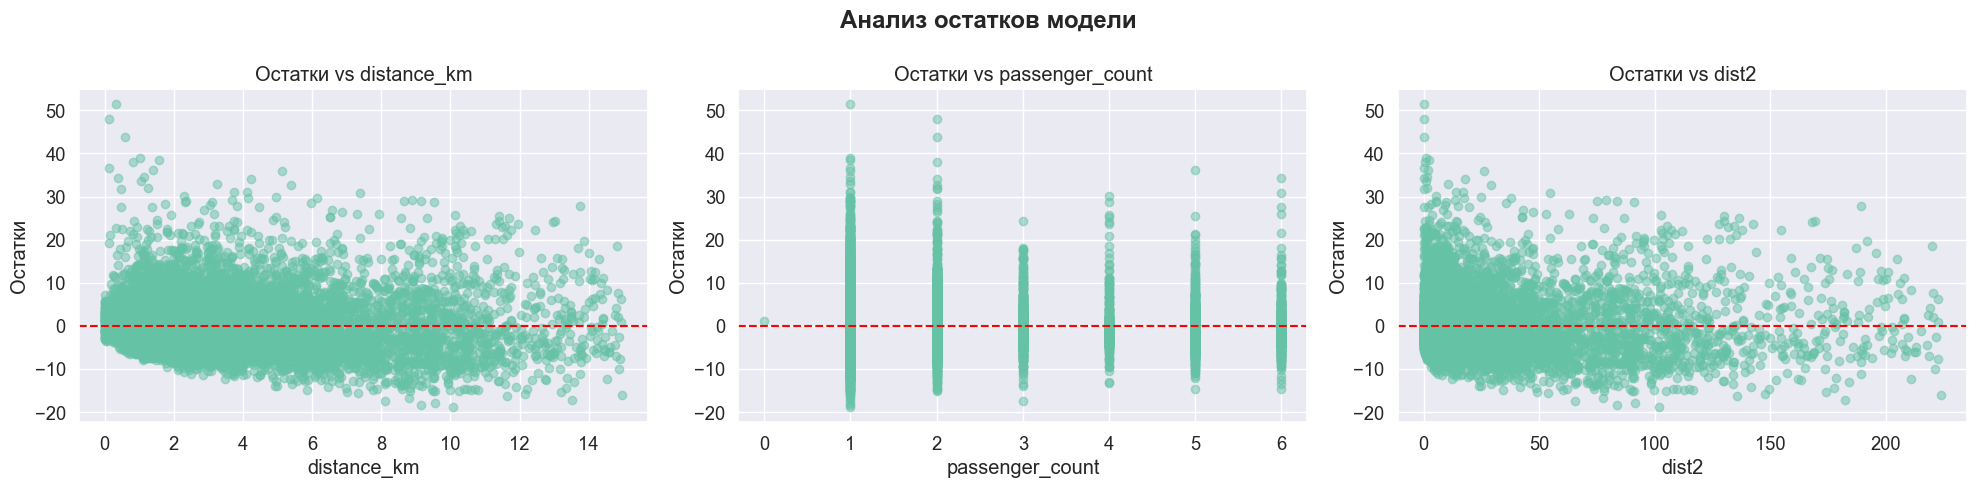

In [ ]:
residuals = lm_results.resid

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

features = ['distance_km', 'passenger_count', 'dist2']

for i, feature in enumerate(features):
    ax[i].scatter(x_train[feature], residuals, alpha=0.5)
    ax[i].axhline(0, color='red', linestyle='--')
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel('Остатки')
    ax[i].set_title(f'Остатки vs {feature}')

fig.suptitle('Анализ остатков модели', fontweight='bold')

plt.tight_layout()
plt.show()

Скорее всего вы ответите «да» на предыдущий вопрос.

Тем не менее, на практике для статистического анализа модели всегда **рекомендуется всегда использовать оценки дисперсии, устойчивые к гетероскедастичности**. Их применение корректно даже в случае гомоскедастичности, соответственно, используя всегда устойчивые оценки мы повышаем надежность модели.

В данном случае гетероскедастичность вполне ожидаема. Чем больше расстояние поездки, тем больше разброс в длительности из-за множества случайных факторов, которые невозможно предсказать заранее.


**5.** **Доверительные и предсказательные интервалы**

Наша следующая цель &mdash; построить *доверительные* интервалы для *среднего* времени поездки и *предсказательные* интервалы для *фактического* времени поездки.

Сначала построим наглядные графики зависимости интервалов от одного признака &mdash; расстояние поездки. Для этого зафиксируйте значения всех остальных признаков (средним или медианой) и создайте сетку значений для расстояния. Например, от 0 до 15 км с шагом в 50-100 метров.

*Замечание.* Если вы использовали производные признаки от расстояния (например, квадрат расстояния), то такие признаки тоже нужно пересчитать по сетке.

In [ ]:
dist_grid = np.linspace(0, 15, num=300)

feature_means = x_train.mean()

grid_data = dict()

for col in x_train.columns:
    grid_data[col] = np.full(shape=dist_grid.shape, fill_value=feature_means[col])

grid_data = pd.DataFrame(grid_data)
grid_data["distance_km"] = dist_grid
grid_data["dist2"] = dist_grid ** 2
grid_data["log_dist"] = np.log1p(dist_grid)
grid_data_with_const = sm.add_constant(grid_data, has_constant='add')
grid_data_np = np.array(grid_data_with_const)

Постройте *доверительные* интервалы для созданной выше сетки и визуализируйте их.

In [ ]:
def plot_regression_only_confidence_intervals(
    model_results: sm.regression.linear_model.RegressionResultsWrapper,
    grid_data_np: np.ndarray,
    dist_grid: np.ndarray,
    alpha: float = 0.95
) -> None:

    predictions = model_results.get_prediction(grid_data_np)
    prediction_summary = predictions.summary_frame(alpha=1 - alpha)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_train["distance_km"], y=y_train, alpha=0.3, label="Обучающие данные", color="#20b2aa")
    plt.plot(
        dist_grid,
        prediction_summary["mean"],
        color="#ff2400",
        label="Предсказание модели"
    )
    plt.fill_between(
        dist_grid,
        prediction_summary["mean_ci_lower"],
        prediction_summary["mean_ci_upper"],
        color="#8b00ff",
        alpha=0.5,
        label=f"{int(alpha * 100)}% Доверительный интервал"
    )
    plt.xlabel("Расстояние (км)")
    plt.ylabel("Продолжительность поездки (мин)")
    plt.title("Предсказания модели с доверительными интервалами", fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()

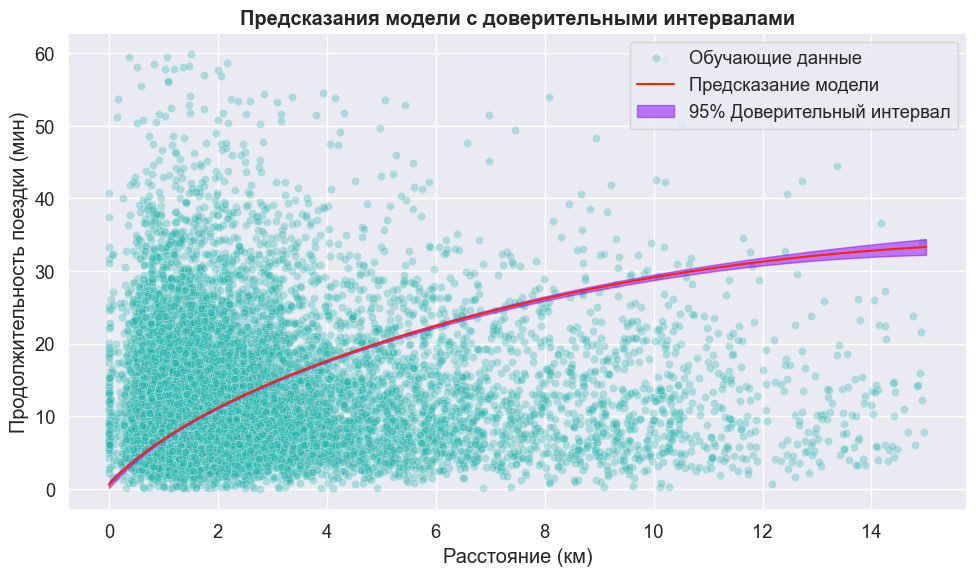

In [ ]:
plot_regression_only_confidence_intervals(
    lm_results,
    grid_data_np,
    dist_grid,
    alpha=0.95
)

На занятии мы обсудили, что для построения предсказательных интервалов нужно оценить зависимость дисперсии шума от признаков. Один из способов это сделать — построить еще одну регрессионную модель для предсказания квадрата остатка основной модели.

Создайте такую модель и оцените её качество. Не забудьте, что предсказания квадрата остатка не могут быть отрицательными.

In [ ]:
resid2 = lm_results.resid**2

variance_model = LinearRegression()

x_var_train, x_var_test, y_var_train,  y_var_test = train_test_split( x_train[["distance_km"]], resid2, test_size=0.2, random_state=42)

variance_model.fit(x_var_train, y_var_train)

y_var_pred = variance_model.predict(x_var_test)
y_var_pred = np.clip(y_var_pred, a_min=0, a_max=None)

var_r2_score = r2_score(y_var_test, y_var_pred)
var_rmse = root_mean_squared_error(y_var_test, y_var_pred)
var_mae = mean_absolute_error(y_var_test, y_var_pred)
var_mape = mean_absolute_percentage_error(y_var_test, y_var_pred)

print(f'Variance Model R2: {var_r2_score}')
print(f'Variance Model RMSE: {var_rmse}')
print(f'Variance Model MAE: {var_mae}')
print(f'Variance Model MAPE: {var_mape}')

Variance Model R2: 0.0575041994940918
Variance Model RMSE: 70.61921574914098
Variance Model MAE: 30.15597581337591
Variance Model MAPE: 1478.8822821457516


In [ ]:
def calculate_predictive_interval(
    lm_results: RegressionResultsWrapper,
    variance_model: RegressorMixin,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
) -> pd.DataFrame:
    """Рассчитывает гетероскедастичный предиктивный интервал для регрессионной модели,
    который учитывает непостоянную дисперсию ошибок (гетероскедастичность).

    Args:
        lm_results: Результаты обученной основной регрессионной модели из `statsmodels`.
        variance_model: Экземпляр НЕОБУЧЕННОЙ регрессионной модели из scikit-learn
            для моделирования дисперсии.
        X_train (pd.DataFrame): Данные (признаки), на которых была обучена
            основная модель `lm_results`. Используются для обучения `variance_model`.
        X_test (pd.DataFrame): Данные (признаки), для которых необходимо построить
            предиктивный интервал.

    Returns:
        pd.DataFrame: DataFrame, аналогичный выводу `.summary_frame()`, но с
            добавленными колонками `obs_ci_lower_het` и `obs_ci_upper_het`,
            содержащими границы гетероскедастичного предиктивного интервала.
    """

    # Таргет вспомогательной модели - квадраты остатков
    resid2 = lm_results.resid**2

    # Обучаем регрессию: resid^2 ~ X_train
    variance_model.fit(X_train, resid2)

    # Получаем стандартные предсказания от statsmodels для X_test
    pred_summary = lm_results.get_prediction(X_test).summary_frame(alpha=0.05)

    # Предсказываем дисперсию ошибки sigma^2(x) для X_test
    sigma2_pred = variance_model.predict(X_test)

    # Убедимся, что предсказанная дисперсия не отрицательна
    sigma2_pred = np.clip(sigma2_pred, a_min=0, a_max=None)

    # Извлекаем дисперсию среднего предсказания, это и есть x_0^T * D(theta_hat) * x_0
    var_mean_pred = pred_summary["mean_se"] ** 2

    # Считаем полную дисперсию предсказания
    total_pred_variance = var_mean_pred + sigma2_pred
    total_pred_se = np.sqrt(total_pred_variance)

    # Находим квантиль t-распределения
    alpha = 0.05
    degrees_freedom = lm_results.df_resid
    t_crit = sps.t.ppf(1 - alpha / 2, df=degrees_freedom)

    # Вычисляем границы нового интервала
    margin_of_error = t_crit * total_pred_se
    pred_summary["obs_ci_lower_het"] = pred_summary["mean"] - margin_of_error
    pred_summary["obs_ci_upper_het"] = pred_summary["mean"] + margin_of_error

    return pred_summary

In [ ]:
def plot_regression_prediction_intervals(
    train_data: pd.DataFrame,
    pred_summary: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    formula_text: Optional[str] = None,
    pred_interval_cols: Tuple[str, str] = ("obs_ci_lower", "obs_ci_upper"),
    pred_interval_label: str = "95% Предикт. инт.",
) -> None:
    """
    Строит график регрессии с доверительным и предиктивным интервалами.

    Args:
        train_data (pd.DataFrame): DataFrame с исходными данными для scatter plot.
        pred_summary (pd.DataFrame): DataFrame с предсказаниями, полученный из
            `.summary_frame()`. Должен содержать x_col, 'mean', 'mean_ci_lower',
            'mean_ci_upper' и колонки, указанные в pred_interval_cols.
        x_col (str): Название колонки с независимой переменной (ось X).
        y_col (str): Название колонки с зависимой переменной (ось Y).
        title (str): Заголовок графика.
        formula_text (Optional[str], optional): Текст с формулой модели для
            отображения на графике. По умолчанию None (не отображать).
        pred_interval_cols (Tuple[str, str], optional): Кортеж из двух строк с
            названиями колонок для нижней и верхней границ предиктивного
            интервала. По умолчанию ('obs_ci_lower', 'obs_ci_upper').
        pred_interval_label (str, optional): Метка для легенды предиктивного
            интервала. По умолчанию '95% Предикт. инт.'.
    """
    plt.figure(figsize=(10, 6))

    # Исходные данные
    sns.scatterplot(
        x=x_col, y=y_col, data=train_data, alpha=0.5, color="#20b2aa", label="Обучающая выборка"
    )

    # Линия регрессии
    plt.plot(
        pred_summary[x_col],
        pred_summary["mean"],
        color="#ff2400",
        linewidth=2,
        label="Предсказания",
    )

    # Предиктивный интервал
    lower_col, upper_col = pred_interval_cols
    plt.fill_between(
        pred_summary[x_col],
        pred_summary[lower_col],
        pred_summary[upper_col],
        color="#8b00ff",
        alpha=0.2,
        label=pred_interval_label,
    )

    plt.title(title)
    plt.xlabel(f"{x_col}")
    plt.ylabel(f"{y_col}")

    if formula_text:
        plt.text(
            0.05,
            0.95,
            formula_text,
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="grey", alpha=0.2),
        )

    plt.legend(loc=4, fontsize=11)
    plt.show()

In [ ]:
def plot_regression_intervals(
    train_data: pd.DataFrame,
    pred_summary: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    formula_text: Optional[str] = None,
    pred_interval_cols: Tuple[str, str] = ("obs_ci_lower", "obs_ci_upper"),
    pred_interval_label: str = "95% Предикт. инт.",
) -> None:
    """
    Строит график регрессии с доверительным и предиктивным интервалами.

    Args:
        train_data (pd.DataFrame): DataFrame с исходными данными для scatter plot.
        pred_summary (pd.DataFrame): DataFrame с предсказаниями, полученный из
            `.summary_frame()`. Должен содержать x_col, 'mean', 'mean_ci_lower',
            'mean_ci_upper' и колонки, указанные в pred_interval_cols.
        x_col (str): Название колонки с независимой переменной (ось X).
        y_col (str): Название колонки с зависимой переменной (ось Y).
        title (str): Заголовок графика.
        formula_text (Optional[str], optional): Текст с формулой модели для
            отображения на графике. По умолчанию None (не отображать).
        pred_interval_cols (Tuple[str, str], optional): Кортеж из двух строк с
            названиями колонок для нижней и верхней границ предиктивного
            интервала. По умолчанию ('obs_ci_lower', 'obs_ci_upper').
        pred_interval_label (str, optional): Метка для легенды предиктивного
            интервала. По умолчанию '95% Предикт. инт.'.
    """
    plt.figure(figsize=(10, 6))

    # Исходные данные
    sns.scatterplot(
        x=x_col, y=y_col, data=train_data, alpha=0.5, color="#20b2aa", label="Обучающая выборка"
    )

    # Линия регрессии
    plt.plot(
        pred_summary[x_col],
        pred_summary["mean"],
        color="#ff2400",
        linewidth=2,
        label="Предсказания",
    )

    # Доверительный интервал
    plt.fill_between(
        pred_summary[x_col],
        pred_summary["mean_ci_lower"],
        pred_summary["mean_ci_upper"],
        color="#8b00ff",
        alpha=0.7,
        label="95% Доверит. инт.",
    )

    # Предиктивный интервал
    lower_col, upper_col = pred_interval_cols
    plt.fill_between(
        pred_summary[x_col],
        pred_summary[lower_col],
        pred_summary[upper_col],
        color="#8b00ff",
        alpha=0.2,
        label=pred_interval_label,
    )

    plt.title(title)
    plt.xlabel(f"{x_col}")
    plt.ylabel(f"{y_col}")

    if formula_text:
        plt.text(
            0.05,
            0.95,
            formula_text,
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="grey", alpha=0.2),
        )

    plt.legend(loc=4, fontsize=11)
    plt.show()

Теперь все готово для построения предсказательного интервала. Постройте его и визуализируйте.

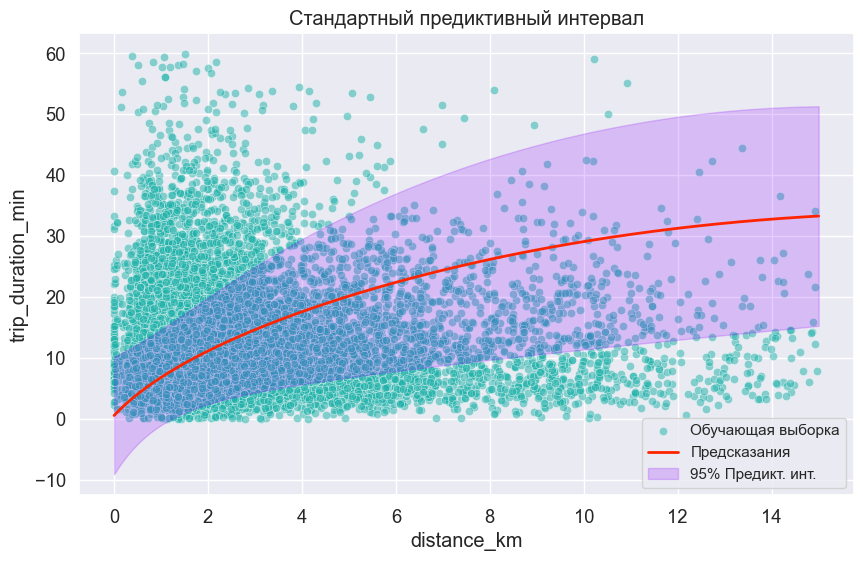

In [ ]:
x_train_with_const = sm.add_constant(x_train, has_constant='add')
x_train_with_const_np = np.array(x_train_with_const)

pred_summary = calculate_predictive_interval(
    lm_results, LinearRegression(), x_train_with_const_np, grid_data_np
)

plot_data = pd.concat([grid_data, pred_summary], axis=1)

train = pd.concat([x_train, y_train], axis=1)

plot_regression_prediction_intervals(
    train_data=train,
    pred_summary=plot_data,
    x_col="distance_km",
    y_col="trip_duration_min",
    title="Стандартный предиктивный интервал",
    pred_interval_cols=("obs_ci_lower_het", "obs_ci_upper_het"),
)

Выберите случайных 50-100 поездок из тестовой выборки и постройте для них оба вида интервала. Визуализируйте эти интервалы на графике (может помочь `plt.errorbar`).

Какие выводы можно сделать про эти два вида интервалов?

...

Наконец, оценим, насколько корректно мы построили предсказательные интервалы. Оцените долю покрытия предсказательным интервалом *фактического* времени поездки по *всем* точкам тестовой выборки.

In [ ]:
...

**Общие выводы по задаче**

...

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД